# Install Dependencies-Do use VENV to protect your python 

Run by hand
```SHELL
    conda install -c conda-forge poppler
    pip install Pillow==9.0.0
    conda install -c conda-forge gdal rasterio geopandas geoplot
    conda install cartopy=0.21
    conda install matplotlib=3.5.2
```

In [1]:
import matplotlib.pyplot as plt
import geoplot
import geoplot.crs as gcrs
import geopandas as gpd
from shapely.geometry import Point, shape
from shapely.validation import explain_validity
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import concurrent.futures
from shapely.geometry import box

# Load and plot

In [2]:
geo_NC = gpd.read_file(
    "NC_counties.geojson"
)
geo_nearby = gpd.read_file("merged_output.geojson")
geo_NC

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,37,037,01008544,37037,0500000US37037,Chatham,Chatham County,06,H1,G4020,450,20500,None,A,1765028677,70582736,+35.7049939,-079.2514542,"POLYGON ((-79.24113 35.57054, -79.24138 35.570..."
1,37,001,01008531,37001,0500000US37001,Alamance,Alamance County,06,H1,G4020,268,15500,None,A,1096742604,27933991,+36.0439535,-079.4005733,"POLYGON ((-79.26824 35.90918, -79.26791 35.909..."
2,37,057,01008548,37057,0500000US37057,Davidson,Davidson County,06,H1,G4020,268,49180,None,A,1432725178,37607387,+35.7951312,-080.2071070,"POLYGON ((-80.39431 35.97276, -80.39417 35.972..."
3,37,069,01008553,37069,0500000US37069,Franklin,Franklin County,06,H1,G4020,450,39580,None,A,1273761680,7173998,+36.0882406,-078.2830903,"POLYGON ((-78.12969 36.23955, -78.12958 36.239..."
4,37,155,01026130,37155,0500000US37155,Robeson,Robeson County,06,H1,G4020,246,31300,None,A,2453481926,5076395,+34.6392096,-079.1008811,"POLYGON ((-79.12835 34.88294, -79.12795 34.883..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37,175,01008589,37175,0500000US37175,Transylvania,Transylvania County,06,H1,G4020,120,14820,None,A,979943598,5091023,+35.2101025,-082.8166660,"POLYGON ((-82.79776 35.36129, -82.79772 35.361..."
96,37,171,01008587,37171,0500000US37171,Surry,Surry County,06,H1,G4020,268,34340,None,A,1379541810,10392706,+36.4154160,-080.6864631,"POLYGON ((-80.44603 36.45461, -80.44639 36.448..."
97,37,043,01008546,37043,0500000US37043,Clay,Clay County,06,H1,G4020,None,None,None,A,556849483,15046554,+35.0529971,-083.7522638,"POLYGON ((-83.86551 35.12734, -83.86540 35.127..."
98,37,055,01026133,37055,0500000US37055,Dare,Dare County,06,H1,G4020,545,28620,None,A,992558551,3000513281,+35.6062688,-075.7675364,"POLYGON ((-75.81311 36.22356, -75.79310 36.227..."


Text(0.5, 1.0, 'NC nearby')

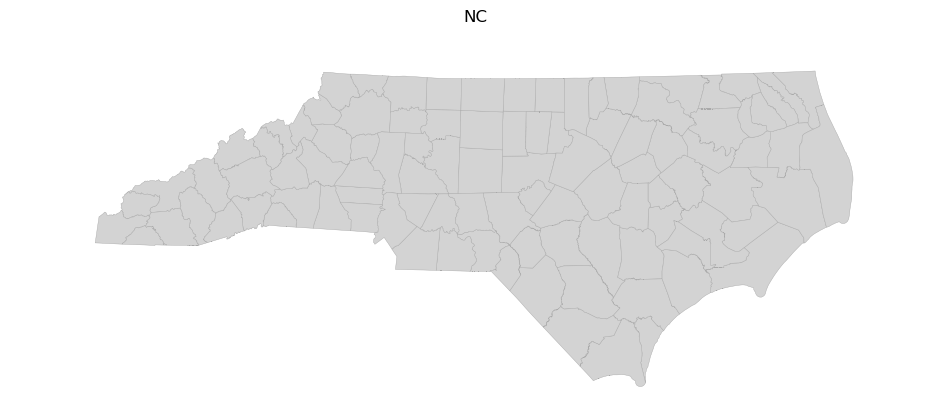

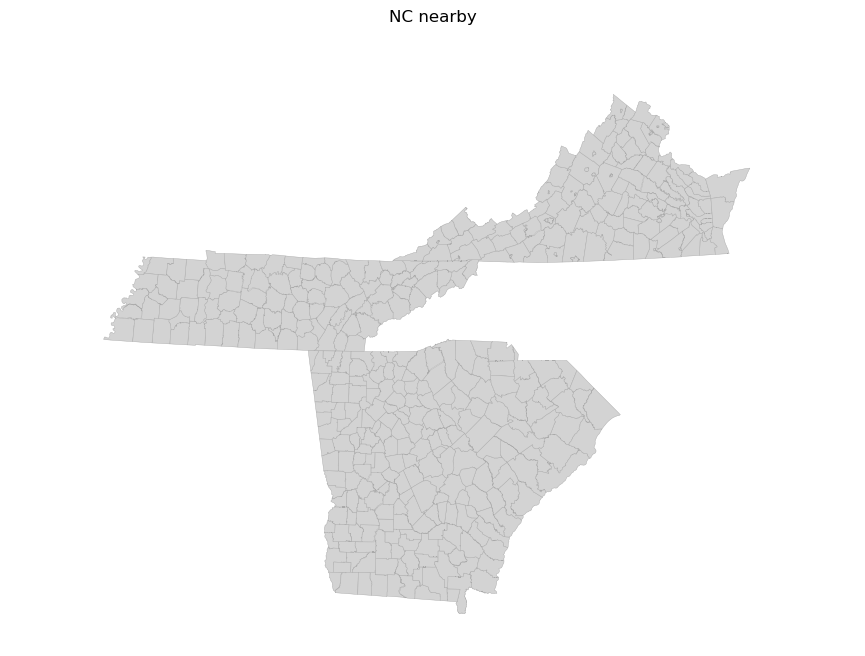

In [17]:
geoplot.polyplot(
    geo_NC,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
)
plt.title("NC")
geoplot.polyplot(
    geo_nearby,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
)
plt.title("NC nearby")

In [10]:
geo_NC_slice = geo_NC[["NAME","geometry"]]
geo_NC_slice["Nums"] = pd.Series(np.arange(100))
geo_NC_slice

/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,NAME,geometry,Nums
0,Chatham,"POLYGON ((-79.24113 35.57054, -79.24138 35.570...",0
1,Alamance,"POLYGON ((-79.26824 35.90918, -79.26791 35.909...",1
2,Davidson,"POLYGON ((-80.39431 35.97276, -80.39417 35.972...",2
3,Franklin,"POLYGON ((-78.12969 36.23955, -78.12958 36.239...",3
4,Robeson,"POLYGON ((-79.12835 34.88294, -79.12795 34.883...",4
...,...,...,...
95,Transylvania,"POLYGON ((-82.79776 35.36129, -82.79772 35.361...",95
96,Surry,"POLYGON ((-80.44603 36.45461, -80.44639 36.448...",96
97,Clay,"POLYGON ((-83.86551 35.12734, -83.86540 35.127...",97
98,Dare,"POLYGON ((-75.81311 36.22356, -75.79310 36.227...",98


/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/mapclassify/classifiers.py:1860: UserWarning: Numba not installed. Using slow pure python version.
  warnings.warn(


<GeoAxesSubplot:>

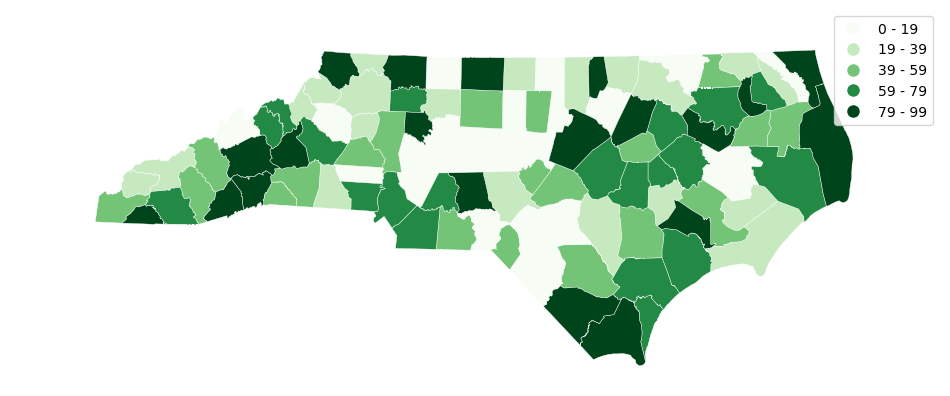

In [19]:

geoplot.choropleth(
    geo_NC_slice,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='white',
    linewidth=.3,
    figsize=(12, 8),
    hue="Nums",
    cmap='Greens', 
    scheme='FisherJenks',
    legend=True,
    
)

In [20]:
np.random.seed(42)
points_data = {
    "geometry": [
        Point(np.random.normal(-80, 1), np.random.normal(35, 1)) for _ in range(1000)
    ]
}
points= gpd.GeoDataFrame(points_data)
points


,geometry
0,POINT (-79.50329 34.86174)
1,POINT (-79.35231 36.52303)
2,POINT (-80.23415 34.76586)
3,POINT (-78.42079 35.76743)
4,POINT (-80.46947 35.54256)
...,...
995,POINT (-79.19959 35.75429)
996,POINT (-78.81109 35.70830)
997,POINT (-79.64855 36.07015)
998,POINT (-80.02652 34.11813)


<GeoAxesSubplot:xlabel='None', ylabel='None'>

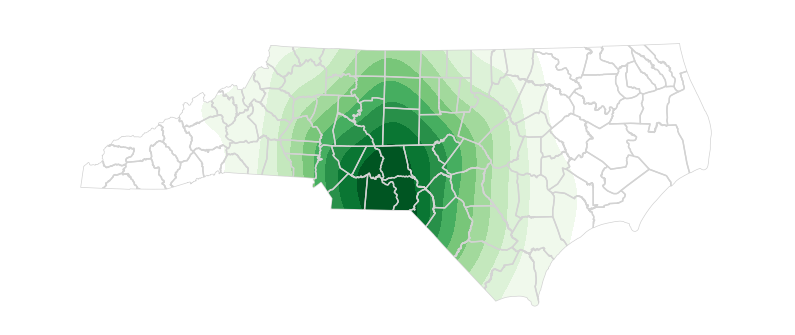

In [21]:
ax0 = geoplot.kdeplot(
    points,
    cmap="Greens",
    fill=True,
    clip=geo_NC_slice[["NAME","geometry"]],
    projection=gcrs.AlbersEqualArea(),
    figsize=(10, 10)
)
geoplot.polyplot(geo_NC_slice[["NAME","geometry"]], zorder=1, ax=ax0, edgecolor="lightgrey")

/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/geoplot/geoplot.py:615: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(


<GeoAxesSubplot:>

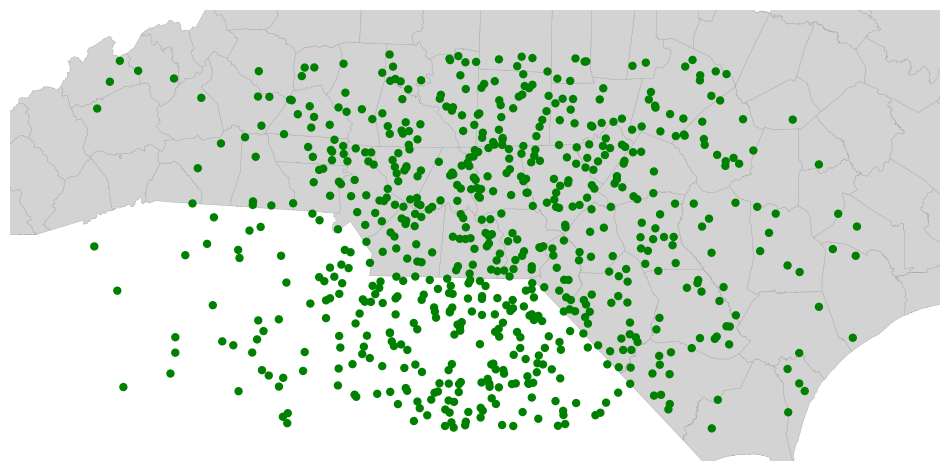

In [22]:

bbox = box(-85, 34, -75, 36)  # Adjust coordinates as needed for your area

#Clip points to the bounding box
points_clipped = points[points.within(bbox)]

ax = geoplot.polyplot(
    geo_NC_slice, 
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
    )
geoplot.pointplot(points_clipped, 
                ax=ax,
                figsize=(12, 8),
                projection=gcrs.AlbersEqualArea(),
                s=5,  # Adjust point size
                color="green"  # Point color
                )


Add Hue

In [23]:
np.random.seed(42)
points_data = {
    "geometry": [
        Point(np.random.normal(-80, 1), np.random.normal(35, 1)) for _ in range(1000)
    ]
}
points= gpd.GeoDataFrame(points_data)
points['Nums'] = np.random.randint(0, 3000, 1000)

/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/geoplot/geoplot.py:615: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(


<GeoAxesSubplot:>

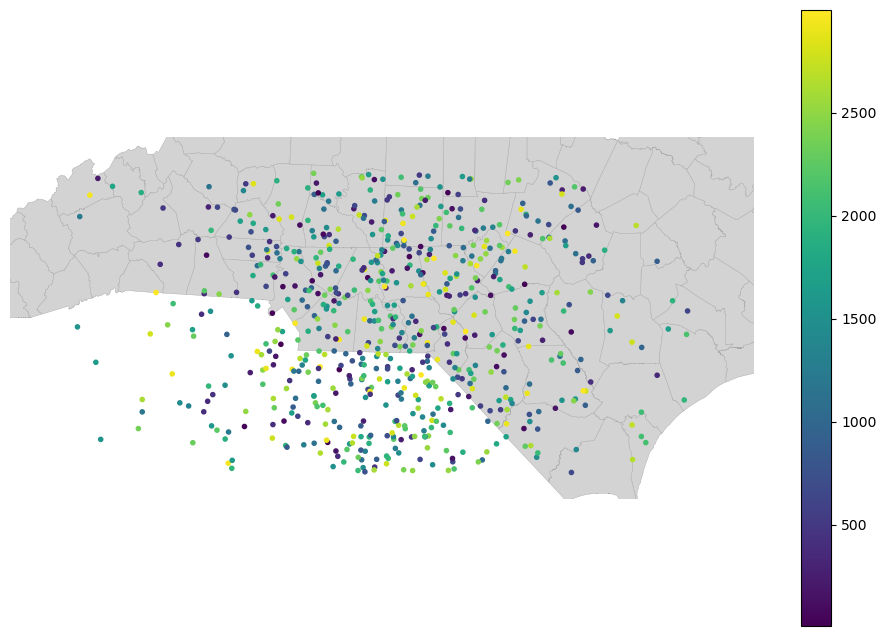

In [24]:

bbox = box(-85, 34, -75, 36)  # Adjust coordinates as needed for your area

#Clip points to the bounding box
points_clipped = points[points.within(bbox)]

ax = geoplot.polyplot(
    geo_NC_slice, 
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
    )
geoplot.pointplot(points_clipped, 
                ax=ax,
                figsize=(12, 8),
                projection=gcrs.AlbersEqualArea(),
                s=3,  # Adjust point size
                hue = "Nums",
                legend=True
                )


# Now try business

In [3]:
conn = sqlite3.connect("./NCCP.db")
cur = conn.cursor()

In [4]:
df_bus = pd.read_sql("SELECT * FROM Business",conn)

In [5]:
df_bus['geometry'] = df_bus.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
df_bus

/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,Company Name,Physical Address,Phone,FAX,Web,Business Description,NAICS,Employee(s),Annual Sales,Contact Person,Industry Description,Stock Exchange,Latitude,Longitude,County,geometry
0,RusticHeartsBakery-GiftShop,"512HarrisAveRaeford,NC28376-3114",9100001111,NaN,None,Bakers-Retail,311811,2,"$88,000",None,RetailBakeries,None,34.977103,-79.232812,Hoke,POINT (-79.232812 34.977103)
1,Starbucks,"4425ParkRd#100Charlotte,NC28209-3402",7045272463,NaN,STARBUCKS.COM,CoffeeShops,722515,15,"$855,000",PamelaJames,SnackandNonalcoholicBeverageBars,None,35.171288,-80.850528,Mecklenburg,POINT (-80.850528 35.171288)
2,StokeCharlotte,"100WTradeStCharlotte,NC28202-2133",7040001111,NaN,STOKECHARLOTTE.COM,Restaurants,722511,113,"$6,440,000",KatelynCooper,Full-ServiceRestaurants,None,35.227748,-80.843380,Mecklenburg,POINT (-80.84338 35.227748)
3,Subway,"1245NBrightleafBlvd#8Smithfield,NC27577-4229",9199896869,NaN,RESTAURANTS.SUBWAY.COM,Limited-ServiceRestaurant,722513,6,"$256,000",MoriahFrazier,Limited-ServiceRestaurants,None,35.521463,-78.313382,Johnston,POINT (-78.313382 35.521463)
4,MatrixNewHomesCorp,"6604EWTHarrisBlvd#C2Charlotte,NC28215-5123",7040001111,NaN,None,HomeBuilders,236115,3,"$1,138,000",OlgaLMartinez,NewSingle-FamilyHousingConstruction(exceptFor-...,None,35.229877,-80.729166,Mecklenburg,POINT (-80.72916600000001 35.229877)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370895,Star7LLC,"7741STryonStCharlotte,NC28217-3301",7040001111,NaN,None,Attorneys,541110,2,"$356,000",SunitaSingh,OfficesofLawyers,None,35.147162,-80.925607,Mecklenburg,POINT (-80.925607 35.147162)
370896,CGroupHomeCareAgencyLLC,"701SGeorgeSt#12Goldsboro,NC27530-5702",9192224119,NaN,None,HomeHealthService,621610,3,"$182,000",ValerieCox,HomeHealthCareServices,None,35.376505,-78.004421,Wayne,POINT (-78.00442099999999 35.376505)
370897,MastertechServices,"320HarlandaleDrWilmington,NC28411-9628",9102975110,NaN,MASTERTECHSERVICES.COM,Appliances-Household-Major-Repairing,811412,2,"$193,000",JamieStrickland,ApplianceRepairandMaintenance,None,34.261884,-77.791148,New Hanover,POINT (-77.79114800000001 34.261884)
370898,ClevelandCountyEmergency,"100JusticePlShelby,NC28150-4638",7044844841,7.044845e+09,CLEVELANDCOUNTY.COM,CountyGovernment-PublicOrder&Safety,922190,5,None,PerryDavis,"OtherJustice,PublicOrder,andSafetyActivities",None,35.290760,-81.535987,Cleveland,POINT (-81.53598700000001 35.29076)


In [6]:
points = df_bus[["geometry","Annual Sales"]]

In [7]:
# Replace NaN with "0" as a string
points['Annual Sales'] = points['Annual Sales'].fillna("0")
# Remove dollar signs and commas, then convert to numeric
points['Annual Sales'] = points['Annual Sales'].str.replace(r"[\$,]", "", regex=True)
# Convert to integers (ensuring no NaN remains)
points['Annual Sales'] = pd.to_numeric(points['Annual Sales'], errors='coerce').fillna(0).astype(int)

points



/var/folders/s2/6ffr7pmd1tv4rnht_h6c6hrr0000gn/T/ipykernel_53681/895820129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['Annual Sales'] = points['Annual Sales'].fillna("0")
/var/folders/s2/6ffr7pmd1tv4rnht_h6c6hrr0000gn/T/ipykernel_53681/895820129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['Annual Sales'] = points['Annual Sales'].str.replace(r"[\$,]", "", regex=True)
/var/folders/s2/6ffr7pmd1tv4rnht_h6c6hrr0000gn/T/ipykernel_53681/895820129.py:6: SettingWithCopyWarning: 
A valu

,geometry,Annual Sales
0,POINT (-79.232812 34.977103),88000
1,POINT (-80.850528 35.171288),855000
2,POINT (-80.84338 35.227748),6440000
3,POINT (-78.313382 35.521463),256000
4,POINT (-80.72916600000001 35.229877),1138000
...,...,...
370895,POINT (-80.925607 35.147162),356000
370896,POINT (-78.00442099999999 35.376505),182000
370897,POINT (-77.79114800000001 34.261884),193000
370898,POINT (-81.53598700000001 35.29076),0


In [8]:
points = gpd.GeoDataFrame(points, geometry='geometry')

<GeoAxesSubplot:xlabel='None', ylabel='None'>

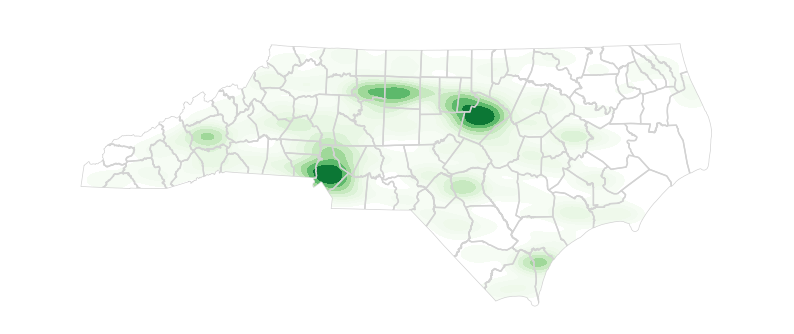

In [11]:
ax0 = geoplot.kdeplot(
    points,
    cmap="Greens",
    fill=True,
    clip=geo_NC_slice[["NAME","geometry"]],
    projection=gcrs.AlbersEqualArea(),
    figsize=(10, 10)
)
geoplot.polyplot(geo_NC_slice[["NAME","geometry"]], zorder=1, ax=ax0, edgecolor="lightgrey")


/Users/sean/miniconda3/envs/py38/lib/python3.8/site-packages/geoplot/geoplot.py:615: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(


<GeoAxesSubplot:>

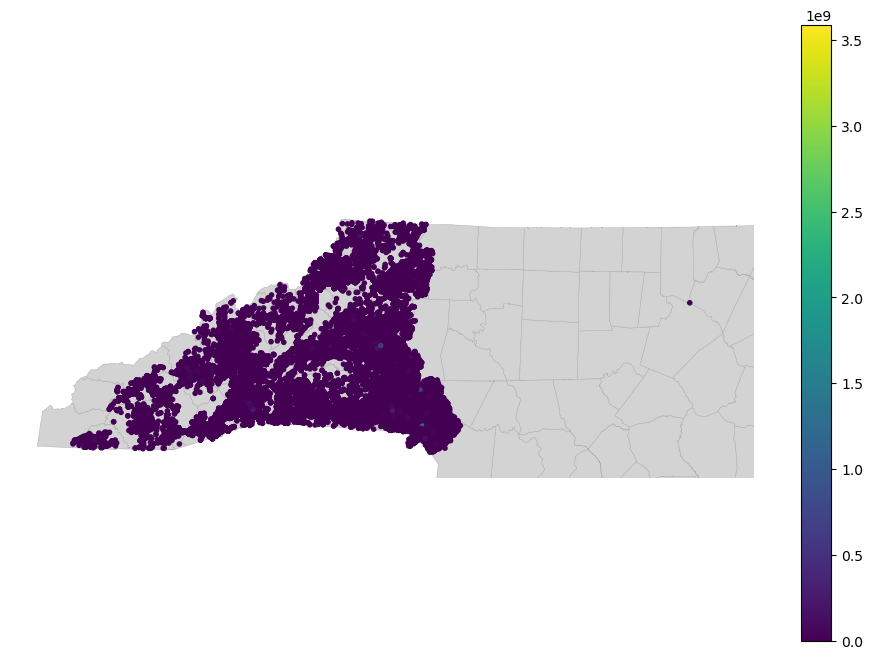

In [32]:

ax = geoplot.polyplot(
    geo_NC_slice, 
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
    )
geoplot.pointplot(points, 
                ax=ax,
                figsize=(12, 8),
                projection=gcrs.AlbersEqualArea(),
                s=3,  # Adjust point size
                hue = "Annual Sales",
                legend=True
                )